# Simualting the waveguide mode using meep

Zhaohua Tian
2021 07 10

## Introduction
In this notebook, I will try two different ways to simualte the waveguide mode and its mode profiles and waveg vectors etc.

## The MPB Method

In [8]:
import meep as mp
from meep import mpb
import numpy as np
from matplotlib import pyplot as plt

# Then the wavelength
omega = 1/0.78
material_SiN=mp.Medium(index=2.02)
width_guide=0.65
height_guide=0.25
resolution=200
size_cal_y=2
size_cal_z=2

geometry = [mp.Block(material=material_SiN, 
                     size=mp.Vector3(mp.inf,width_guide, height_guide),
                     center=mp.Vector3(0, 0, height_guide/2))]
geometry_lattice = mp.Lattice(size=mp.Vector3(0, size_cal_y, size_cal_z))

num_modes = 4

ms = mpb.ModeSolver(
    geometry_lattice = geometry_lattice,
    geometry         = geometry,
    resolution       = resolution,
    num_bands        = num_modes
)

E = []
store_fields = lambda ms_temp, mode: E.append(ms_temp.get_efield(which_band=mode,bloch_phase=False))    

k = ms.find_k(
    mp.NO_PARITY,
    omega, # omega
    1, # band_min
    num_modes, # band_max
    mp.Vector3(1,0,0), # korig_and_kdir
    1e-4, # tol
    omega * 2, # kmag_guess
    omega * 0.1, # kmag_min
    omega * 2, # kmag_max
    store_fields, # band_funcs
)
neff=k[0]/omega
eps = ms.get_epsilon()
eps_arr=np.transpose(np.array(eps))

Initializing eigensolver data
Computing 4 bands with 1e-07 tolerance
Working in 3 dimensions.
Grid size is 1 x 400 x 400.
Solving for 4 bands at a time.
Creating Maxwell data...
Mesh size is 3.
Lattice vectors:
     (1, 0, 0)
     (0, 2, 0)
     (0, 0, 2)
Cell volume = 4
Reciprocal lattice vectors (/ 2 pi):
     (1, -0, 0)
     (-0, 0.5, -0)
     (0, -0, 0.5)
Geometric objects:
     block, center = (0,0,0.125)
          size (1e+20,0.65,0.25)
          axes (1,0,0), (0,1,0), (0,0,1)
Geometric object tree has depth 1 and 1 object nodes (vs. 1 actual objects)
Initializing epsilon function...
Allocating fields...
Solving for band polarization: .
Initializing fields to random numbers...
1 k-points
  Vector3<2.564102564102564, 0.0, 0.0>
elapsed time for initialization: 0.14168453216552734
solve_kpoint (2.5641,0,0):
freqs:, k index, k1, k2, k3, kmag/2pi, band 1, band 2, band 3, band 4
Solving for bands 1 to 4...
    near maximum in trace
    linmin: converged after 8 iterations.
    iteratio

Current band: 1
Current band: 2
Current band: 3
Current band: 4


<ipython-input-10-f30ee5293a99>:12: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(x_grid,y_grid,eps.transpose(), cmap='binary')
<ipython-input-10-f30ee5293a99>:13: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(x_grid,y_grid,np.abs(Ex), cmap='jet', alpha=0.9)


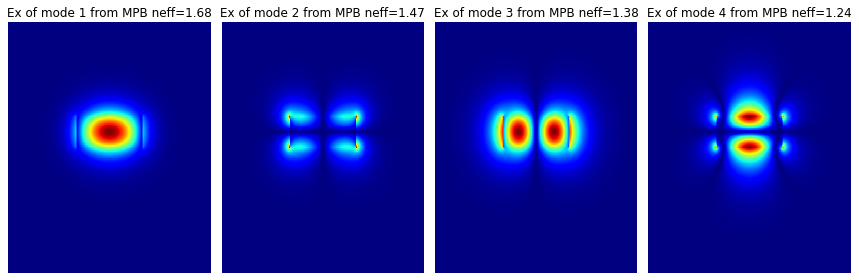

In [10]:
# %%
x_list=np.linspace(-size_cal_y/2,size_cal_y/2,resolution*2)
y_list=np.linspace(-size_cal_z/2,size_cal_z/2,resolution*2)
x_grid,y_grid=np.meshgrid(x_list,y_list)

plt.figure(figsize=(12,4))
# Plot the E fields
for mode in range(num_modes):
    Ex=np.squeeze(E[mode][:,:,0,1]).transpose()
    print('Current band: {}'.format(mode+1))
    plt.subplot(1,num_modes,1+mode)
    plt.pcolormesh(x_grid,y_grid,eps.transpose(), cmap='binary')
    plt.pcolormesh(x_grid,y_grid,np.abs(Ex), cmap='jet', alpha=0.9)
    plt.axis('off')
    st_title='Ex of mode '+str(mode+1)+' from MPB neff=' +str('%.2f' %(k[mode]/omega))
    plt.title(st_title)
plt.tight_layout()
plt.savefig('SimulatedFieldMPB.png')
plt.show()

and the effective index is as follows

In [ ]:
neff=np.array(k)/omega
print(neff)

## The meep method
we can also simualte the mode profile in meep by creating a simulation project. The geometery can be the same

In [3]:
import meep as mp
from meep import mpb
import numpy as np
from matplotlib import pyplot as plt

#Then the wavelength
omega = 1/0.78
material_SiN=mp.Medium(index=2.02)
width_guide=0.65
height_guide=0.25
resolution=200
size_cal_y=2
size_cal_z=2

geometry = [mp.Block(material=material_SiN, 
                     size=mp.Vector3(mp.inf,width_guide, height_guide),
                     center=mp.Vector3(0, 0, height_guide/2))]
geometry_lattice = mp.Lattice(size=mp.Vector3(0, size_cal_y, size_cal_z))

num_modes = 4

dpml = 0.5
pml_layers = [mp.PML(dpml)]
sim = mp.Simulation(cell_size=mp.Vector3(0,size_cal_y+dpml*2,size_cal_z+dpml*2),
                    resolution=resolution,
                    geometry=geometry,
                    boundary_layers=pml_layers,)

sim.init_sim()
where = mp.Volume(center=mp.Vector3(), size=mp.Vector3(0,size_cal_y,size_cal_y))
direction = mp.X
kpoint = mp.Vector3(1,0,0)

x_list=np.linspace(-size_cal_y/2,size_cal_y/2,resolution*2)
y_list=np.linspace(-size_cal_z/2,size_cal_z/2,resolution*2)
x_grid,y_grid=np.meshgrid(x_list,y_list)
pos_extract=mp.Vector3(np.ravel(x_grid)*0,np.ravel(x_grid),np.ravel(y_grid))
Ex_mp=np.zeros((resolution*2,resolution*2,num_modes),dtype=complex)
# Extract the field in a loop
num_modes=4
k_meep=np.zeros(num_modes)
for mode in range(num_modes):
    print('Simultion Mode'+str(mode+1))
    ed = sim.get_eigenmode(omega, direction, where, mode+1, kpoint, eig_vol=None, match_frequency=True, 
    parity=mp.NO_PARITY, resolution=resolution, eigensolver_tol=1e-12)
    k_meep[mode]=ed.k[0]
    for l in range(resolution*2):
        for m in range(resolution*2):
            Ex_mp[l,m,mode]=ed.amplitude(mp.Vector3(0,x_list[m],y_list[l]),1)

-----------
Initializing structure...
time for choose_chunkdivision = 0.000433207 s
Working in 3D dimensions.
Computational cell is 0.005 x 3 x 3 with resolution 200
     block, center = (0,0,0.125)
          size (1e+20,0.65,0.25)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (4.0804,4.0804,4.0804)
time for set_epsilon = 1.30244 s
-----------
Simultion Mode1
MPB solved for frequency_1(1,0,0) = 0.762832 after 18 iters
MPB solved for frequency_1(2.12344,0,0) = 1.27078 after 10 iters
MPB solved for frequency_1(2.14814,0,0) = 1.28205 after 8 iters
MPB solved for frequency_1(2.14813,0,0) = 1.28205 after 2 iters
Dominant planewave for band 1: (2.148132,-0.000000,0.000000)
Simultion Mode2
MPB solved for frequency_2(1,0,0) = 0.88031 after 26 iters
MPB solved for frequency_2(1.70554,0,0) = 1.20726 after 12 iters
MPB solved for frequency_2(1.88255,0,0) = 1.28176 after 11 iters
MPB solved for frequency_2(1.88324,0,0) = 1.28205 after 6 iters
MPB solved 

Be careful that we need extract the field properties via some methods.

Current band: 1
Current band: 2
Current band: 3
Current band: 4


<ipython-input-7-fbaa5e69185e>:5: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(x_grid,y_grid,np.abs(Ex_mp[:,:,mode]), cmap='jet', alpha=0.9)


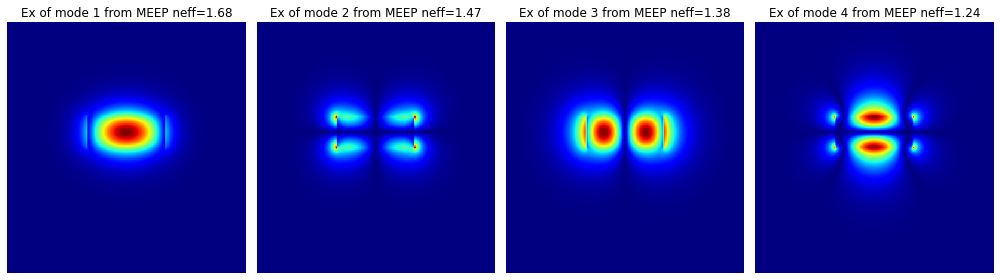

In [7]:
plt.figure(figsize=(14,4))
for mode in range(num_modes):
    print('Current band: {}'.format(mode+1))
    plt.subplot(1,num_modes,1+mode)
    plt.pcolormesh(x_grid,y_grid,np.abs(Ex_mp[:,:,mode]), cmap='jet', alpha=0.9)
    plt.axis('off')
    st_title='Ex of mode '+str(mode+1)+' from MEEP neff=' +str('%.2f' %(k_meep[mode]/omega))
    plt.title(st_title)
plt.tight_layout()
plt.savefig('SimulatedFieldMeep.png')
plt.show()

## Comaprision between meep and MPB

Current band: 1
Current band: 2
Current band: 3
Current band: 4
Current band: 1
Current band: 2
Current band: 3


<ipython-input-12-1a0f972779f9>:5: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(x_grid,y_grid,np.abs(Ex_mp[:,:,mode]), cmap='jet', alpha=0.9)
<ipython-input-12-1a0f972779f9>:13: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(x_grid,y_grid,np.abs(Ex), cmap='jet', alpha=0.9)


Current band: 4


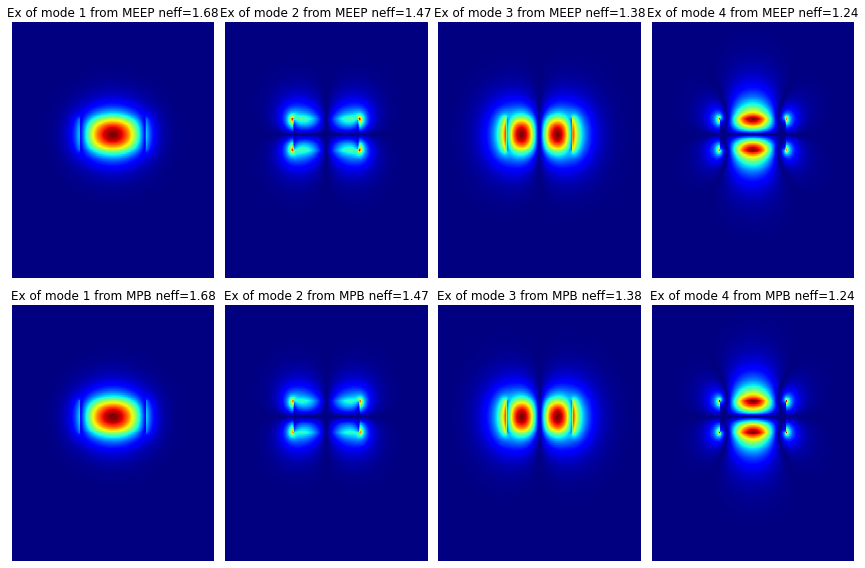

In [12]:
plt.figure(figsize=(12,8))
for mode in range(num_modes):
    print('Current band: {}'.format(mode+1))
    plt.subplot(2,num_modes,1+mode)
    plt.pcolormesh(x_grid,y_grid,np.abs(Ex_mp[:,:,mode]), cmap='jet', alpha=0.9)
    plt.axis('off')
    st_title='Ex of mode '+str(mode+1)+' from MEEP neff=' +str('%.2f' %(k_meep[mode]/omega))
    plt.title(st_title)
for mode in range(num_modes):
    Ex=np.squeeze(E[mode][:,:,0,1]).transpose()
    print('Current band: {}'.format(mode+1))
    plt.subplot(2,num_modes,1+mode+num_modes)
    plt.pcolormesh(x_grid,y_grid,np.abs(Ex), cmap='jet', alpha=0.9)
    plt.axis('off')
    st_title='Ex of mode '+str(mode+1)+' from MPB neff=' +str('%.2f' %(k[mode]/omega))
    plt.title(st_title)

plt.tight_layout()
plt.savefig('SimulatedFieldCompare.png')
plt.show()

We can see that the results agrees well with each other. We can choose different methods to simulate the mode profiles. This is just a simple step for us to simulate the mode profile and effective index.